# Landmark detection using MTCNN

## Imports

In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Paths

In [2]:
POSE_MODEL_PATH = '../pose_model'
DNN_PROTO_TEXT_PATH = '../face_detection_model/deploy.prototxt'
DNN_MODEL_PATH = '../face_detection_model/res10_300x300_ssd_iter_140000.caffemodel'
FER_PATH = "../dataset/fer-2013-images.npy"
OUTPUT_PATH = "../outputs/fer-2013-mtcnn-landmarks.npz"

## Face Detector class

In [3]:
class FaceDetector:
    """Detect human face from image"""

    def __init__(self,
                 dnn_proto_text=DNN_PROTO_TEXT_PATH,
                 dnn_model=DNN_MODEL_PATH):
        """Initialization"""
        self.face_net = cv2.dnn.readNetFromCaffe(dnn_proto_text, dnn_model)
        self.detection_result = None

    def get_face_boxes(self, image, threshold=0.5):
        """
        Get the bounding box of faces in image using dnn.
        """
        rows, cols, _ = image.shape

        confidences = []
        face_boxes = []

        self.face_net.setInput(cv2.dnn.blobFromImage(
            image, 1.0, (300, 300), (104.0, 177.0, 123.0), False, False))
        detections = self.face_net.forward()

        for result in detections[0, 0, :, :]:
            confidence = result[2]
            if confidence > threshold:
                x_left_bottom = int(result[3] * cols)
                y_left_bottom = int(result[4] * rows)
                x_right_top = int(result[5] * cols)
                y_right_top = int(result[6] * rows)
                confidences.append(confidence)
                face_boxes.append(
                    [x_left_bottom, y_left_bottom, x_right_top, y_right_top])

        self.detection_result = [face_boxes, confidences]

        return confidences, face_boxes

    def draw_all_result(self, image):
        """Draw the detection result on image"""
        for facebox, conf in self.detection_result:
            cv2.rectangle(image, (facebox[0], facebox[1]),
                          (facebox[2], facebox[3]), (0, 255, 0))
            label = "face: %.4f" % conf
            label_size, base_line = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

            cv2.rectangle(image, (facebox[0], facebox[1] - label_size[1]),
                          (facebox[0] + label_size[0],
                           facebox[1] + base_line),
                          (0, 255, 0), cv2.FILLED)
            cv2.putText(image, label, (facebox[0], facebox[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

## Mark Detector class

In [4]:
class MarkDetector:
    """Facial landmark detector by Convolutional Neural Network"""

    def __init__(self, saved_model=POSE_MODEL_PATH):
        """Initialization"""
        # A face detector is required for mark detection.
        self.face_detector = FaceDetector()

        self.cnn_input_size = 128
        self.marks = None

        # Restore model from the saved_model file.
        self.model = tf.saved_model.load(saved_model)

    @staticmethod
    def draw_box(image, boxes, box_color=(255, 255, 255)):
        """Draw square boxes on image"""
        for box in boxes:
            cv2.rectangle(image,
                          (box[0], box[1]),
                          (box[2], box[3]), box_color, 3)

    @staticmethod
    def move_box(box, offset):
        """Move the box to direction specified by vector offset"""
        left_x = box[0] + offset[0]
        top_y = box[1] + offset[1]
        right_x = box[2] + offset[0]
        bottom_y = box[3] + offset[1]
        return [left_x, top_y, right_x, bottom_y]

    @staticmethod
    def get_square_box(box):
        """Get a square box out of the given box, by expanding it."""
        left_x = box[0]
        top_y = box[1]
        right_x = box[2]
        bottom_y = box[3]

        box_width = right_x - left_x
        box_height = bottom_y - top_y

        # Check if box is already a square. If not, make it a square.
        diff = box_height - box_width
        delta = int(abs(diff) / 2)

        if diff == 0:                   # Already a square.
            return box
        elif diff > 0:                  # Height > width, a slim box.
            left_x -= delta
            right_x += delta
            if diff % 2 == 1:
                right_x += 1
        else:                           # Width > height, a short box.
            top_y -= delta
            bottom_y += delta
            if diff % 2 == 1:
                bottom_y += 1

        # Make sure box is always square.
        assert ((right_x - left_x) == (bottom_y - top_y)), 'Box is not square.'

        return [left_x, top_y, right_x, bottom_y]

    @staticmethod
    def box_in_image(box, image):
        """Check if the box is in image"""
        rows = image.shape[0]
        cols = image.shape[1]
        return box[0] >= 0 and box[1] >= 0 and box[2] <= cols and box[3] <= rows

    def extract_cnn_facebox(self, image):
        """Extract face area from image."""
        _, raw_boxes = self.face_detector.get_face_boxes(
            image=image, threshold=0.9)

        a = []
        for box in raw_boxes:
            # Move box down.
            # diff_height_width = (box[3] - box[1]) - (box[2] - box[0])
            offset_y = int(abs((box[3] - box[1]) * 0.1))
            box_moved = self.move_box(box, [0, offset_y])

            # Make box square.
            facebox = self.get_square_box(box_moved)

            if self.box_in_image(facebox, image):
                a.append(facebox)

        return a

    def detect_marks(self, image_np):
        """Detect marks from image"""

        # # Actual detection.
        predictions = self.model.signatures["predict"](
            tf.constant(image_np, dtype=tf.uint8))

        # Convert predictions to landmarks.
        marks = np.array(predictions['output']).flatten()[:136]
        marks = np.reshape(marks, (-1, 2))

        return marks

    @staticmethod
    def draw_marks(image, marks):
        """Draw mark points on image"""
        for mark in marks:
            image[int(mark[1])][int(mark[0])] = [100, 20, 60]

## Model Wrapper

In [5]:
# Keep only RoI of dataset images
mark_detector = MarkDetector()

def apply_region_on_image(target_image, source_image, landmarks, padding = 3):
  top_left = np.min(landmarks, axis=0)
  bottom_right = np.max(landmarks, axis=0)
  top = int(top_left[1]) - padding
  bottom = int(bottom_right[1]) + padding
  left = int(top_left[0]) - padding
  right = int(bottom_right[0]) + padding

  target_image[top:bottom, left:right] = source_image[top:bottom, left:right]
  return target_image

def apply_roi(data):
  ROI_applied_images = []
  for i in range(len(data)):
    img = (np.repeat(data[i], 3, axis=2)).astype(int)
    facebox = [0, 0, 47, 47]
    marks = mark_detector.detect_marks([img])
    marks *= (facebox[2] - facebox[0])
    marks[:, 0] += facebox[0]
    marks[:, 1] += facebox[1]

    ROI_applied_image = np.ones_like(data[i])

    ROI_applied_image = apply_region_on_image(ROI_applied_image, data[i], marks[27:36], 2) # Nose
    ROI_applied_image = apply_region_on_image(ROI_applied_image, data[i], marks[36:42], 2) # Right eye
    ROI_applied_image = apply_region_on_image(ROI_applied_image, data[i], marks[42:48], 2) # Left eye
    ROI_applied_image = apply_region_on_image(ROI_applied_image, data[i], marks[49:68], 2) # Lips
  
    ROI_applied_images.append(ROI_applied_image)

  return np.array(ROI_applied_images)

## FER-2013

In [6]:
dataset_images = np.load(FER_PATH)
print(dataset_images.shape)

(35887, 48, 48, 1)


In [7]:
ROI_applied_dataset_images = apply_roi(dataset_images)
print(ROI_applied_dataset_images.shape)

(35887, 48, 48, 1)


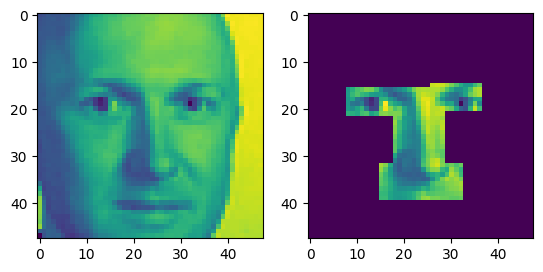

In [8]:
index = 32
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(dataset_images[index].squeeze(axis=2))
ax2.imshow(ROI_applied_dataset_images[index].squeeze(axis=2))
plt.show()

In [9]:
np.savez_compressed(OUTPUT_PATH, landmarks=ROI_applied_dataset_images)